# Support Vector Machines

In this section of the assignment, you will get to implement Support Vector Machines which are among the best (and many believe are indeed the best) “off-the-shelf” supervised learning algorithm.

This section is further divided into 3 subsections.


*   In the first subsection, you will work on a synthetic dataset and visualize the boundary predicted by SVM. You will also vary the value of C-parameter and see how the decision boundary changes. **Please note that you cannot use inbuilt sklearn function for SVM in this sub-section**. You can only use a QCQP (Quadratically Constrained Quadratic Program) solver like CVXPY. 

  References which you may find helpful for this subsection: 
  
  1.   https://www.cvxpy.org/
  2.   https://www.cvxpy.org/examples/basic/quadratic_program.html

  Note that in this section you are expected to show how you derived the Quadratically Constrained form(which can be passed into the solver) from the basic principles of SVM algorithm
*  In the next subsection you will use be using the famous MNIST dataset to explore various kernels and report the results. **Please note you may use inbuilt sklearn SVM functions in this subsection**


In [ ]:
!pip install numpy
!pip install matplotlib
!pip install cvxpy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

### Subsection 1

In [ ]:
# Feel free to use this helper function to visualize 2D points X with labels +1 or -1
def plot_points(X, Y):
    reds = []
    blues = []
    for i in range(Y.shape[0]):
        if Y[i] == 1:
            reds.append(X[i])
        else:
            blues.append(X[i])
    reds = np.array(reds)
    blues = np.array(blues)
    plt.scatter(reds[:, 0], reds[:, 1], c = 'r')
    plt.scatter(blues[:, 0], blues[:, 1], c = 'b')

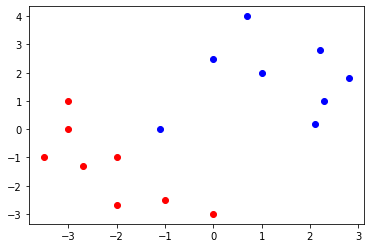

In [ ]:
# Create Synthetic Data and visualize the points
X = np.array([[-3.5, -1], [-3, 0], [-3, 1], [-2.7, -1.3], [-2, -1], [-2, -2.7], 
              [-1, -2.5], [0, -3], [-1.1, 0], [0, 2.5], [1, 2], [0.7, 4], 
              [2.1, 0.2], [2.3, 1], [2.8, 1.8], [2.2, 2.8]])
y = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1])

plot_points(X, y)
plt.show()

In the next cell you are required to derive the Quadratic Constrained Quadratic form of SVM **without soft constraints** from the basic principles. Start with the idea that SVM tries to maximize the margin and then derive the form which you can feed to the solver.

Please print the values of w, b. 

**Note: You are also required to upload a page of the derivation. You may also type it in markdown here.**

**Note: You cannot use sklearn SVM functions here.**

<img src="images/svm1.jpg" width="400">
<img src="images/svm2.jpg" width="400">
<img src="images/svm3.jpg" width="400">
<img src="images/svm4.jpg" width="400">

In [ ]:
import cvxopt as cvxopt
from cvxopt import solvers as cvxopt_solvers

In [ ]:
# Write your code here
class svm:
    def __init__(self, C=0, threshold=1e-5):
        self.C = C
        self.threshold = threshold

    def get_support(self):
        return self.X, self.targets

    def get_support_idx(self):
        return self.sv

    def get_classifier(self):
        return self.w.flatten(), self.b[0]

    def construct_kernel(self, X, y):
        self.K = np.dot(y*X,(y*X).T) * 1.

    def train_kernel_svm(self, X, targets):
        targets = targets.reshape(-1,1)

        self.N = np.shape(X)[0]
        self.construct_kernel(X,targets)

        q = -np.ones((self.N, 1))
        P = self.K
        A = targets.reshape(1,-1) * 1.
        b = np.zeros(1)

        G = -np.identity(self.N) if self.C == 0 else np.vstack((np.identity(self.N)*-1., np.identity(self.N)))
        h = np.zeros(self.N) if self.C == 0 else np.hstack((np.zeros(self.N), self.C * np.ones(self.N)))
        
        # Solver parameters
        cvxopt_solvers.options['show_progress'] = False
        cvxopt_solvers.options['feastol'] = 1e-10
        cvxopt_solvers.options['reltol'] = 1e-10
        cvxopt_solvers.options['abstol'] = 1e-10

        # quadratic solver of cvxopt
        sol = cvxopt_solvers.qp(cvxopt.matrix(P), cvxopt.matrix(q), cvxopt.matrix(G), cvxopt.matrix(h), cvxopt.matrix(A), cvxopt.matrix(b))

        # Get the Lagrange multipliers out of the solution dictionary
        lambdas = np.array(sol['x'])
        # print(f"lambdas: {lambdas[lambdas > self.threshold]}")

        # Find the (indices of the) support vectors, which are the vectors with non-zero Lagrange multipliers
        self.sv = np.where(lambdas > self.threshold)[0]
        self.nsupport = len(self.sv)
        # print("Number of support vectors = ", self.nsupport)

        # Keep the data corresponding to the support vectors
        self.lambdas = lambdas[self.sv]
        self.targets = targets[self.sv]

        self.X = X[self.sv, :]
        self.w = ((targets * lambdas).T @ X).reshape(-1,1)
        S = (lambdas > self.threshold).flatten()
        self.b = targets[S] - np.dot(X[S], self.w)

        def classify(Y,soft=False):
            K = np.dot(Y, X.T)

            sz = np.shape(Y)[0]
            self.y = np.zeros((sz, 1))
            for j in range(sz):
                for i in range(self.nsupport):
                    self.y[j] += self.lambdas[i]*self.targets[i]*K[j, i]
                self.y[j] += self.b

            if soft==False:
                return np.sign(self.y)
            else:
                return self.y

        self.classify = classify

In [ ]:
clf = svm()
clf.train_kernel_svm(X,y)
slope, intercept = clf.get_classifier()
print(f'W = {slope}\nB = {intercept}')

W = [-1.73913043 -1.30434783]
B = [-2.91304348]


In the next cell you are required to visualize the boundary predicted by the solver. You may want to revise up on how to plot the a line given w, b. Please plot w vector as well as the margin lines

You may want to create a function to plot the line of separation as you would require this frequently in the subsequent parts of the assignment.

In [ ]:
# Write your code here
def plot_boundary(X, Y, slope, intercept):
    plt.clf()
    plt.scatter(X[:, 0][Y==1], X[:, 1][Y==1], color = 'red')
    plt.scatter(X[:, 0][Y!=1], X[:, 1][Y!=1], color = 'blue')

    xmin = X[:,0].min()
    xmax = X[:,0].max()
    ymin = X[:,1].min()
    ymax = X[:,1].max()

    xd = [xmin-1, xmax+1]
    xd = np.array(xd)
    yd = slope*xd + intercept

    print("xd:", xd)
    print("yd:", yd)

    plt.plot(xd, yd, 'k', lw=1, ls='--')
    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')

    plt.fill_between(xd, yd, ymin-1, color='tab:blue', alpha=0.2)
    plt.fill_between(xd, yd, ymax+1, color='tab:orange', alpha=0.2)
    plt.xlim(xmin-0.5, xmax+0.5)
    plt.ylim(ymin-0.5, ymax+0.5)
    plt.show()

xd: [-4.5  3.8]
yd: [ 3.76666667 -7.3       ]


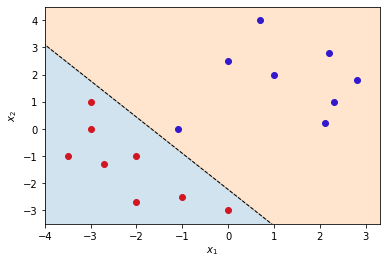

In [ ]:
m = -slope[0]/slope[1]
b = -intercept/slope[1]
plot_boundary(X,y,m,b)
# margin lines are plotted further below

In the next cell please plot only the support vectors along with the boundary, w vector, and margins. 

**Note: You are not supposed to hard-code the points here.**

In [ ]:
# Write your code here
X_supp, y_supp = clf.get_support()
y_supp = y_supp.reshape(-1,)

w, b = clf.get_classifier()
slope = -w[0]/w[1]
intercept = -b/w[1]

xmin = X_supp[:,0].min()
xmax = X_supp[:,0].max()
ymin = X_supp[:,1].min()
ymax = X_supp[:,1].max()

xd = np.linspace(xmin-1,xmax+1)
yd = slope*xd + intercept

margin = 1 / np.sqrt(np.sum(w**2))
yy_down = yd + slope * margin
yy_up = yd - slope * margin

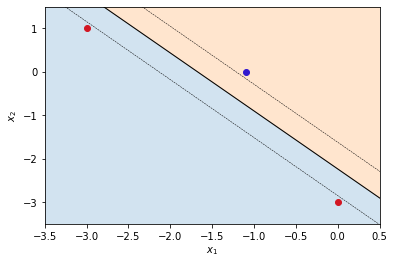

In [ ]:
plt.scatter(X_supp[:, 0][y_supp==1], X_supp[:, 1][y_supp==1], color = 'red')
plt.scatter(X_supp[:, 0][y_supp!=1], X_supp[:, 1][y_supp!=1], color = 'blue')

plt.plot(xd, yd, 'k-', lw=1)
plt.plot(xd,yy_down,'k--',lw=0.5)
plt.plot(xd,yy_up,'k--',lw=0.5)
plt.fill_between(xd, yd, ymin-1, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax+1, color='tab:orange', alpha=0.2)
plt.xlim(xmin-0.5, xmax+0.5)
plt.ylim(ymin-0.5, ymax+0.5)
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')
plt.show()

In the next cell add the following points:
* (-4, -10) with label 1
* (4, 4) with label -1

Is the decision boundary changed after adding the points? Explain your observations theoretically.

*No, the decision boundary does not change because the newly added points are not the support vectors.*

In [ ]:
# Re-create the Synthetic Data by adding the points and visualize the points
X = np.concatenate((X, [[-4,-10], [4,4]]))
y = np.concatenate((y,[1,-1]))

In [ ]:
# Solve for the decision boundary using this modified dataset
clf = svm()
clf.train_kernel_svm(X,y)
w, b = clf.get_classifier()

xd: [-5.  5.]
yd: [ 4.43333333 -8.9       ]


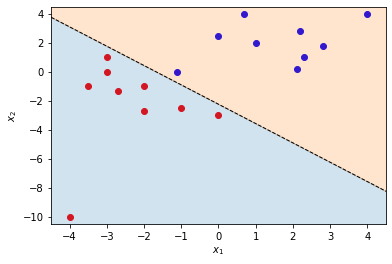

In [ ]:
slope = -w[0]/w[1]
intercept = -b/w[1]
plot_boundary(X,y,slope,intercept)

In the next cell you are required to modify your framing of optimisation problem to incorporate soft constraints also known as slack. Plot the decision boundary, w and margin lines for various values of C: $0.01$, $0.1$, $3$, $10$, $100$.

Explain your results theoretically. How does the boundary change with varying values of C? Why?

=> *By increasing the value of C, the margin moves from soft to hard margin. (accuracy also increases).*

**Note: Use the modified X and y i.e after adding points in previous cell.**

In [ ]:
def common_plot(C,X=X,y=y):
  clf = svm(C)
  clf.train_kernel_svm(X,y)
  w, b = clf.get_classifier()
  slope = -w[0]/w[1]
  intercept = -b/w[1]
  plot_boundary(X,y,slope,intercept)

xd: [-5.  5.]
yd: [ 5.73551311 -5.59782021]


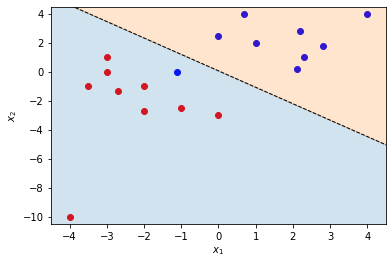

In [ ]:
# Write your code here for C= 0.01
common_plot(C=0.01)

xd: [-5.  5.]
yd: [ 6.03571429 -4.91666667]


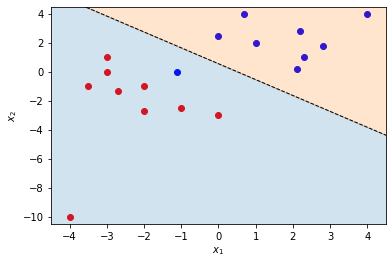

In [ ]:
# Write your code here for C= 0.1
common_plot(C=0.1)

xd: [-5.  5.]
yd: [ 4.43333333 -8.9       ]


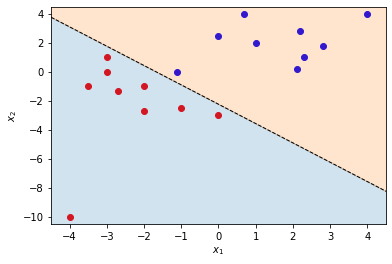

In [ ]:
# Write your code here for C= 3
common_plot(C=3)

xd: [-5.  5.]
yd: [ 4.43333333 -8.9       ]


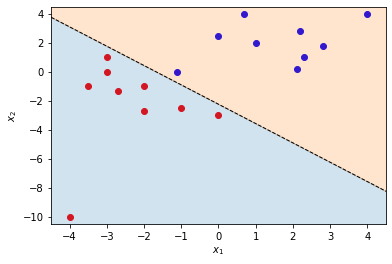

In [ ]:
# Write your code here for C= 10
common_plot(C=10)

xd: [-5.  5.]
yd: [ 4.43333333 -8.9       ]


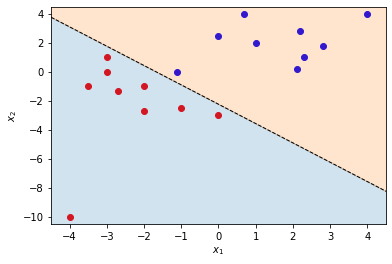

In [ ]:
# Write your code here for C= 100
common_plot(C=100)

Take the case of C = 100 and remove the support vectors. Does the boundary change after the deletion?
Explain why? Show your results by appropriate plots?

**EXPLANATION:**   
This is due to the fact that the support vectors determine how the decision boundary is computed (i.e. decision boundary must be the optimal hyperplane that maximizes the separation from these support vectors). Thus, changing them results in change of support vectors and hence change in the decision boundary respectively.

In [ ]:
# Write your Code here
sv_idx = clf.get_support_idx()
X_supp = np.delete(X, clf.sv, axis=0)
y_supp = np.delete(y,clf.sv, axis=0)

xd: [-5.  5.]
yd: [ 5.13095238 -5.82142857]


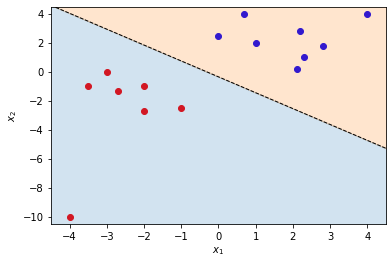

In [ ]:
common_plot(C=100,X=X_supp,y=y_supp)

### Subsection 2

In [ ]:
!pip install python-mnist
!rm -rf samples
!mkdir samples
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -P samples/
!gunzip samples/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -P samples/
!gunzip samples/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -P samples/
!gunzip samples/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -P samples/
!gunzip samples/t10k-labels-idx1-ubyte.gz

--2021-12-01 07:29:31--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘samples/train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.09s   

2021-12-01 07:29:31 (100 MB/s) - ‘samples/train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2021-12-01 07:29:32--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘samples/train-labels-idx1-ubyte.gz’

train-label

In [ ]:
# Import Relevant Packages
from sklearn.svm import SVC
import numpy as np
from mnist.loader import MNIST

In [ ]:
mndata = MNIST('samples')

# Load training dataset
images, labels = mndata.load_training()
l = len(labels)
images_train = np.array(images)
labels_train = np.array(labels)

print(images_train.shape)
print(labels_train.shape)

(60000, 784)
(60000,)


In [ ]:
# Load testing dataset
images, labels = mndata.load_testing()
l = len(labels)
images_test = np.array(images)
labels_test = np.array(labels)

print(images_test.shape)
print(labels_test.shape)

(10000, 784)
(10000,)


- Tweak different parameters like the C Parameter and gamma parameter of the Linear SVM and report the results.
- Experiment different kernels for classification and report the results.

Report accuracy score, F1-score, Confusion matrix and any other metrics you feel useful.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
svm = LinearSVC(dual=False)
svm.fit(images_train, labels_train)
prediction = svm.predict(images_test)

In [ ]:
print(f"Accuracy score with linear kernel: {accuracy_score(labels_test, prediction)}")
print(classification_report(labels_test, prediction))

Accuracy score with linear kernel: 0.9169
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.88      0.90      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.88      0.86      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.87      0.87       974
           9       0.90      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



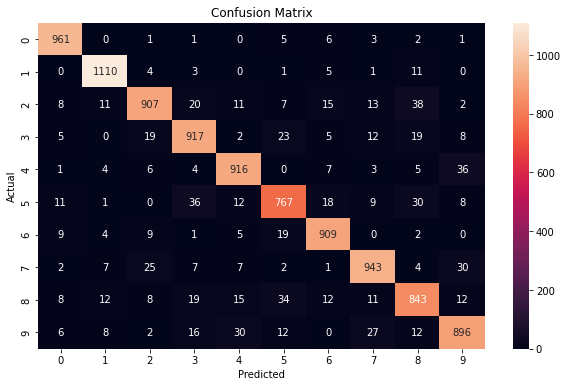

In [ ]:
# confusion matrix
cm = confusion_matrix(labels_test, prediction)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Getting best parameters using GridSearchCV
warnings.filterwarnings('ignore')

In [ ]:
params = {
    "C": [0.01, 0.1, 1, 10, 100],
}

clfs = GridSearchCV(LinearSVC(random_state=42, verbose=2,max_iter=100), params)
clfs.fit(images_train, labels_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

GridSearchCV(estimator=LinearSVC(max_iter=100, random_state=42, verbose=2),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [ ]:
svm = clfs.best_estimator_
prediction = svm.predict(images_test)
print(svm)

LinearSVC(C=0.01, max_iter=100, random_state=42, verbose=2)


Accuracy score with linear kernel: 0.8739
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       980
           1       0.90      0.99      0.94      1135
           2       0.96      0.78      0.86      1032
           3       0.84      0.92      0.88      1010
           4       0.85      0.93      0.89       982
           5       0.84      0.81      0.82       892
           6       0.84      0.96      0.89       958
           7       0.93      0.89      0.91      1028
           8       0.86      0.65      0.74       974
           9       0.85      0.82      0.83      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



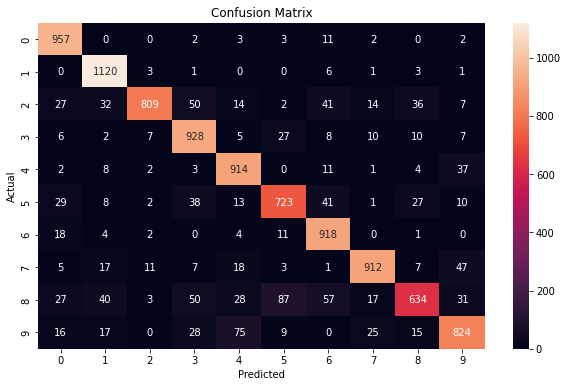

In [ ]:
print(f"Accuracy score with linear kernel: {accuracy_score(labels_test, prediction)}")
print(classification_report(labels_test, prediction))

cm = confusion_matrix(labels_test, prediction)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Accuracy score with poly kernel: 0.9771
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



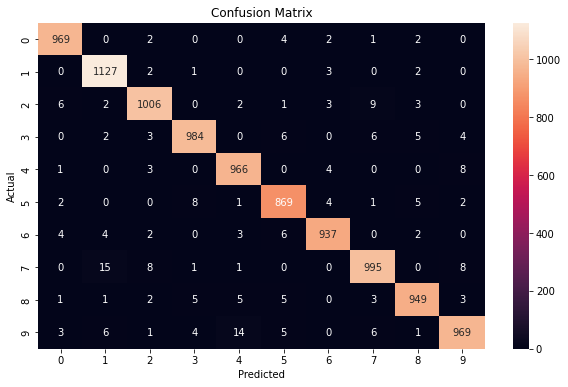

In [ ]:
# SVC with polynomial kernel
svm = SVC(kernel='poly')
svm.fit(images_train, labels_train)
prediction = svm.predict(images_test)
print(f"Accuracy score with poly kernel: {accuracy_score(labels_test, prediction)}")
print(classification_report(labels_test, prediction))

cm = confusion_matrix(labels_test, prediction)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Accuracy score with rbf kernel: 0.9792
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



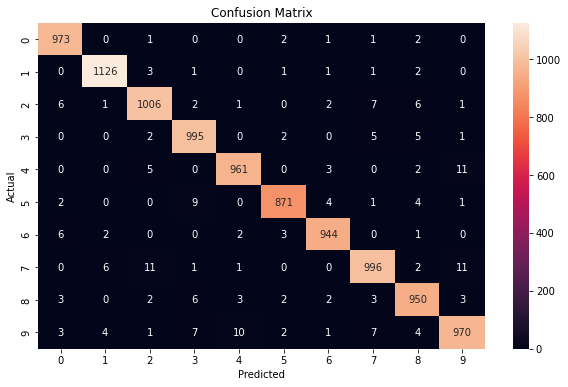

In [ ]:
# SVC with Radial Basis Function Kernel
svm = SVC(kernel='rbf')
svm.fit(images_train, labels_train)
prediction = svm.predict(images_test)
print(f"Accuracy score with rbf kernel: {accuracy_score(labels_test, prediction)}")
print(classification_report(labels_test, prediction))

cm = confusion_matrix(labels_test, prediction)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()